# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

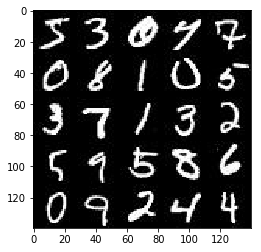

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

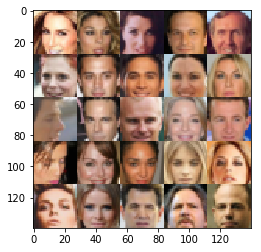

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


f:\program files\python\python36\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='lr')
    
    return input_real, input_z, lr



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        layer = tf.layers.conv2d(images, 64, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.maximum(alpha*layer, layer)
        
        layer = tf.layers.conv2d(layer, 128, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)

        layer = tf.layers.conv2d(layer, 256, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        
        layer = tf.reshape(layer, (-1, 4*4*256))
        logits = tf.layers.dense(layer, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.reshape(layer, (-1, 7, 7, 256))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        
        layer = tf.layers.conv2d_transpose(layer, 128, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        
        layer = tf.layers.conv2d_transpose(layer, 64, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        
        logits = tf.layers.conv2d_transpose(layer, 
                                            out_channel_dim, 
                                            (5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    input_real, input_z, lr = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, *data_shape[1:4])
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    #train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    #train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.8590... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 2.4664... Generator Loss: 1.1313
Epoch 1/2... Discriminator Loss: 2.4555... Generator Loss: 0.1684
Epoch 1/2... Discriminator Loss: 1.9818... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 2.0116... Generator Loss: 0.3830
Epoch 1/2... Discriminator Loss: 1.8093... Generator Loss: 0.4342
Epoch 1/2... Discriminator Loss: 1.8181... Generator Loss: 0.4266
Epoch 1/2... Discriminator Loss: 1.7138... Generator Loss: 0.5208
Epoch 1/2... Discriminator Loss: 1.8243... Generator Loss: 0.4139
Epoch 1/2... Discriminator Loss: 1.5897... Generator Loss: 0.5993


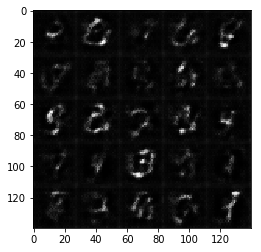

Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 1.0541
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.4753
Epoch 1/2... Discriminator Loss: 1.5963... Generator Loss: 0.4644
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.6204


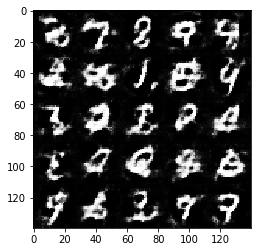

Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.5656... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.6189... Generator Loss: 0.4602
Epoch 1/2... Discriminator Loss: 1.6937... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.3214... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 1.4763... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.8385... Generator Loss: 0.3263
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.6979


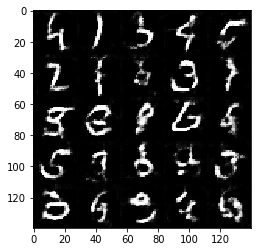

Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.5152... Generator Loss: 0.5976
Epoch 1/2... Discriminator Loss: 1.5280... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.7596
Epoch 1/2... Discriminator Loss: 1.5229... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 0.8191
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.4551
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.5551
Epoch 1/2... Discriminator Loss: 1.5086... Generator Loss: 0.5856
Epoch 1/2... Discriminator Loss: 1.6413... Generator Loss: 0.5301


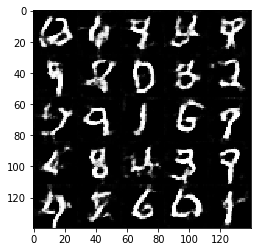

Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.5579
Epoch 1/2... Discriminator Loss: 1.3593... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.4841... Generator Loss: 0.6499
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.6814
Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 1.3071
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.6630


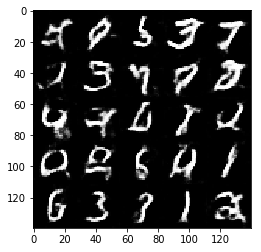

Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.9701
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.4744... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.6699
Epoch 1/2... Discriminator Loss: 1.7758... Generator Loss: 0.3208
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.5191
Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.4639
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.6752


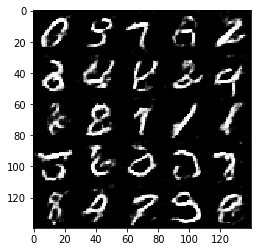

Epoch 1/2... Discriminator Loss: 1.5926... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.5346
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 0.4678
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.7097... Generator Loss: 0.9787


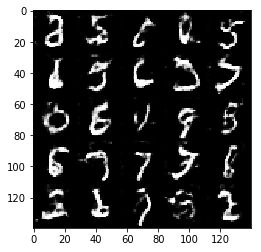

Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.5738
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.3764... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.3996... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.6506
Epoch 1/2... Discriminator Loss: 1.6809... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.4785... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.8898


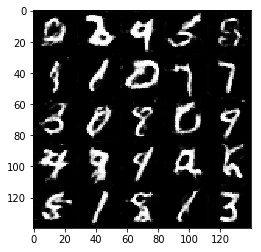

Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.7110... Generator Loss: 0.3887
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.8984
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.9366... Generator Loss: 0.3603
Epoch 1/2... Discriminator Loss: 1.4679... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.5941
Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.6564
Epoch 1/2... Discriminator Loss: 1.3672... Generator Loss: 0.6366


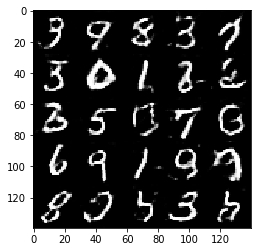

Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.5870
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.6165
Epoch 2/2... Discriminator Loss: 1.6251... Generator Loss: 0.4057
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 1.5110... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.5131... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.6476


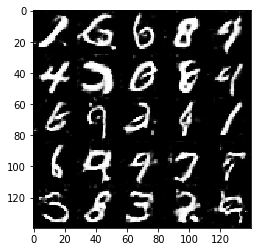

Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.5241
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.2128... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 1.6556... Generator Loss: 0.3563
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.5543... Generator Loss: 0.4348
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.6199
Epoch 2/2... Discriminator Loss: 1.5254... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.6824


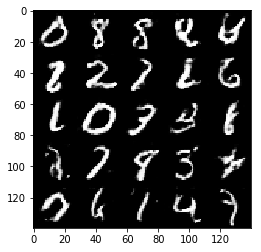

Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.6291
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.5597
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.5624... Generator Loss: 0.5058
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.5754
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.4905... Generator Loss: 0.5532
Epoch 2/2... Discriminator Loss: 1.5305... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 1.4863... Generator Loss: 0.5723


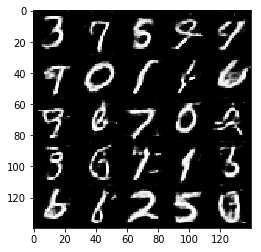

Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.9593
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.9625
Epoch 2/2... Discriminator Loss: 1.5276... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.6993
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 1.6319... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.5476... Generator Loss: 0.4856
Epoch 2/2... Discriminator Loss: 1.3140... Generator Loss: 0.9664
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 1.3007


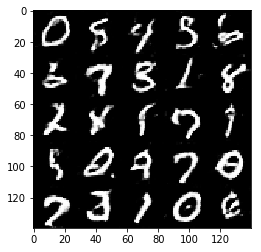

Epoch 2/2... Discriminator Loss: 1.5661... Generator Loss: 0.5461
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 0.9671
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.7452
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.4961... Generator Loss: 0.6042
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.4483... Generator Loss: 0.5619
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.3146... Generator Loss: 0.8008


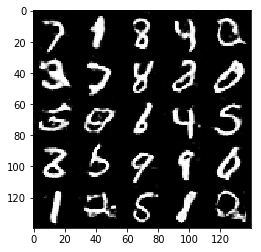

Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.5828
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.6541... Generator Loss: 0.3815
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.8276
Epoch 2/2... Discriminator Loss: 1.4924... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 0.4426
Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 1.0863


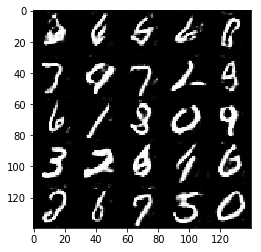

Epoch 2/2... Discriminator Loss: 1.7259... Generator Loss: 0.3636
Epoch 2/2... Discriminator Loss: 1.5087... Generator Loss: 0.5085
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 1.1023
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.7352
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 1.6057... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.7500


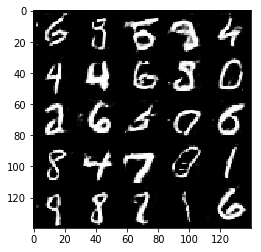

Epoch 2/2... Discriminator Loss: 1.4582... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.5252... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 1.5290... Generator Loss: 0.4418
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.7851
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.6755
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.5064
Epoch 2/2... Discriminator Loss: 1.6199... Generator Loss: 0.3757


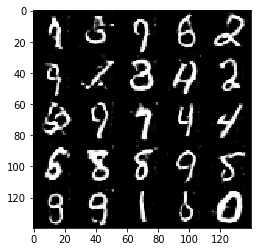

Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 0.5631
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.5510
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 1.3482... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.5482... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.6513... Generator Loss: 0.5968


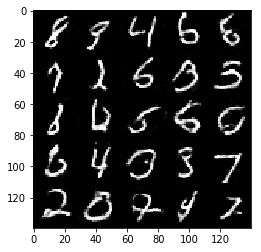

Epoch 2/2... Discriminator Loss: 1.6131... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.3743... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.6169... Generator Loss: 0.5889
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.6632
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.5040


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 2.5787
Epoch 1/1... Discriminator Loss: 2.2638... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 2.3218... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 2.1804... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 2.2000... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.9224... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.8244... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.8706... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.5545... Generator Loss: 0.6932


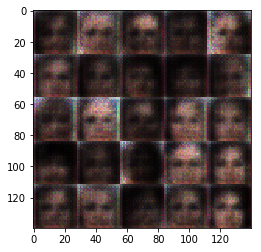

Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.7772... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7016


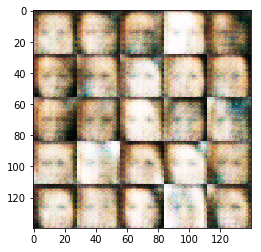

Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.6448... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7200


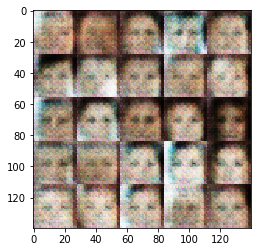

Epoch 1/1... Discriminator Loss: 1.5901... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.6189... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.7037


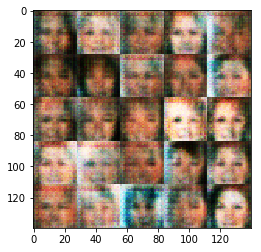

Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7593


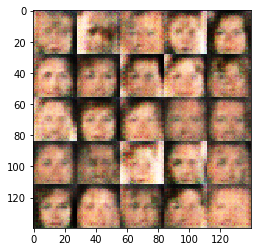

Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.6202... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6997


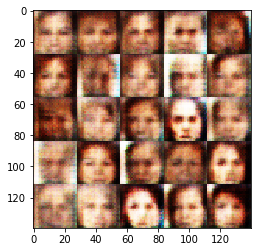

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7047


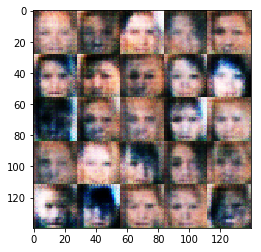

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7215


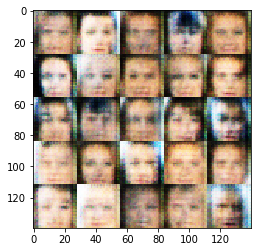

Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7754


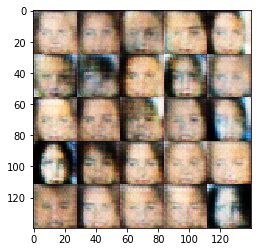

Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7643


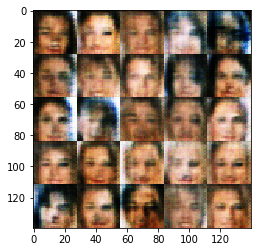

Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7710


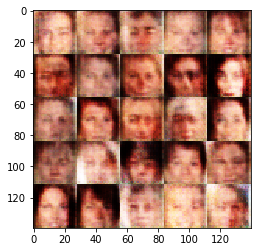

Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7989


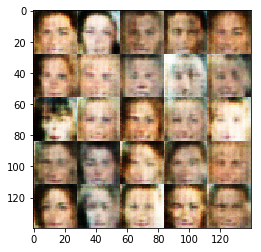

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7928


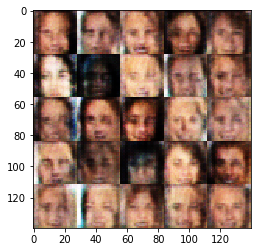

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7572


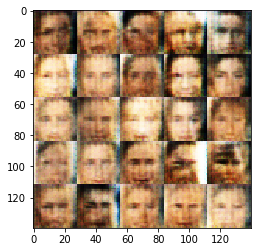

Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8047


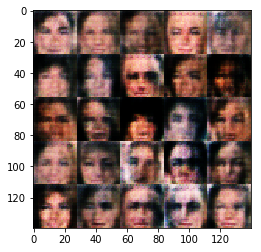

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7660


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.